# 使用MMIO直接驱动测试
# 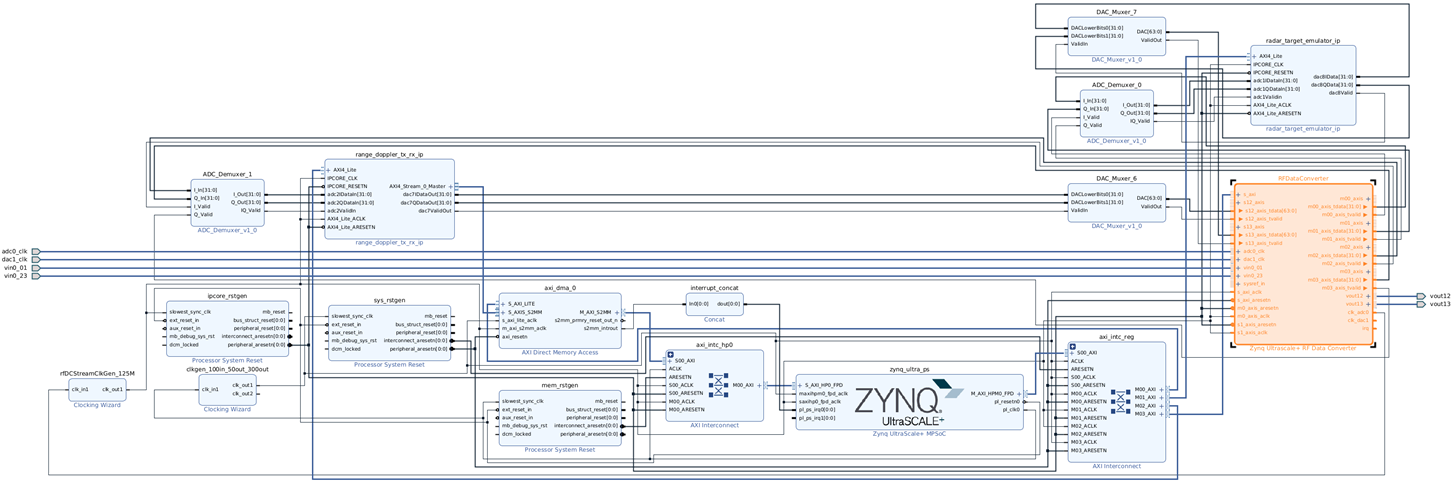
## ADC 时钟 125.0MHz
## DAC 时钟 250.0MHz
## 注意lmx命名规则为LMXA2594_freq.txt

## step 0: 引用必要的库

In [1]:
import os
import xrfclk 

## step 1: 使用xrfclk的_find_devices() 方法找到系统的lmk,lmx设备

In [2]:
def find_lmclk_devices():
    xrfclk.xrfclk._find_devices()
find_lmclk_devices()

In [3]:
xrfclk.lmk_devices

[{'spi_device': PosixPath('/dev/spidev1.1'),
  'compatible': 'lmk04208',
  'num_bytes': 4}]

In [4]:
xrfclk.lmx_devices

[{'spi_device': PosixPath('/dev/spidev1.3'), 'compatible': 'lmx2594'},
 {'spi_device': PosixPath('/dev/spidev1.2'), 'compatible': 'lmx2594'},
 {'spi_device': PosixPath('/dev/spidev1.0'), 'compatible': 'lmx2594'}]

## step 2: 指定一个存储有时钟配置文件的位置，通常时钟配置文件放置在以lmk命名的文件夹里
### 例如时钟配置文件放置在 pynq/xrfclk/

In [5]:
loc = '/home/xilinx/jupyter_notebooks/rfsoc_lfm/xrfclk/'

## step 3: 通常存在一个lmk，一至三个lmx

In [6]:
lmclk_loc = '' # 目录字符串
lmk_loc = ''   # 含文件名的完整路径字符串
lmx_locs = []  # 多个完整路径字符串列表

## step 4: 确定存在时钟配置txt文件的文件夹

In [7]:
for root, dirs, files in os.walk(loc):
        for d in dirs:
            for lmk in xrfclk.lmk_devices:
                if d == lmk['compatible']:
                    lmclk_loc = os.path.join(root, d)
                    break

In [8]:
lmclk_loc

'/home/xilinx/jupyter_notebooks/rfsoc_lfm/xrfclk/lmk04208'

## step 5: 存储所有lmk, lmx文件

In [9]:
for file in os.listdir(lmclk_loc):
        if file.endswith('.txt'):
            if 'LMK' in file:
                lmk_loc = os.path.join(lmclk_loc, file)
            elif 'LMX' in file:
                lmx_locs.append(os.path.join(lmclk_loc, file))
lmx_locs.sort()

In [10]:
lmk_loc

'/home/xilinx/jupyter_notebooks/rfsoc_lfm/xrfclk/lmk04208/LMK04208_122.88.txt'

In [11]:
lmx_locs

['/home/xilinx/jupyter_notebooks/rfsoc_lfm/xrfclk/lmk04208/LMXA2594_250.00.txt',
 '/home/xilinx/jupyter_notebooks/rfsoc_lfm/xrfclk/lmk04208/LMXB2594_250.00.txt',
 '/home/xilinx/jupyter_notebooks/rfsoc_lfm/xrfclk/lmk04208/LMXC2594_125.0.txt']

## step 6: 存储lmk名称和频率值（MHz）和配置寄存器数据

In [12]:
lmk_name = lmk_loc.split('/')[-1]
lmk = lmk_name.strip('.txt').split('_')

with open(lmk_loc, 'r') as file:
        reg = [line.rstrip("\n") for line in file]
        lmk_reg = [int(r.split('\t')[-1], 16) for r in reg]

## step 7: 构建clk_props字典,仅lmk

In [13]:
clk_props = {
    'lmk': {
        'file': lmk_name,
        'loc':  lmk_loc,
        'chip': lmk[0],
        'freq': lmk[1],
        'reg':  lmk_reg
    }
}

## step 8: 存储所有lmx的名称，频率值，各存储器数据

In [14]:
lmxs = []
lmxs_reg = []
for lmx in lmx_locs:
    temp = lmx.split('/')[-1]
    lmx_split = temp.strip('.txt').split('_')
    lmxs.append(lmx_split)
    with open(lmx, 'r') as file:
        reg = [line.rstrip("\n") for line in file]
        lmxs_reg.append([int(r.split('\t')[-1], 16) for r in reg])

## step 9: 扩展clk_props字典，lmx关键字段用LMXA2594类似表示

In [15]:
for i in range(len(lmxs)):
    clk_props.update(
        {lmxs[i][0]: {                 # LMXA2594
            'file': lmxs[i][0],        # LMXA2594
            'loc' : lmx_locs[i],       # /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/xrfclk/lmk04208/LMXA2594_409.6.txt
            'chip': lmxs[i][0],        # LMXA2594
            'freq': lmxs[i][1],        # 409.6
            'reg' : lmxs_reg[i]        # 各寄存器数据
        }
        }
    )

## step 10: 配置lmk

In [16]:
for lmk in xrfclk.lmk_devices:
    xrfclk.xrfclk._write_LMK_regs(clk_props['lmk']['reg'], lmk)

## step 11: 配置lmxs

In [17]:
for i in range(len(lmxs)):
    xrfclk.xrfclk._write_LMX_regs(clk_props[lmxs[i][0]]['reg'], xrfclk.lmx_devices[i])

## step 12: 使能DC

In [18]:
import xrfdc

## step 13: 加载bit

In [19]:
from pynq import Overlay
ol = Overlay('lfm/lfm.bit')
ol.ip_dict

{'radar_target_emulator_ip': {'type': 'mathworks.com:ip:radar_target_emulator_ip:1.0',
  'mem_id': 'AXI4_Lite',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'Component_Name': 'design_1_radar_target_emulator_ip_0',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_BASEADDR': '0xA0000000',
   'C_HIGHADDR': '0xA000FFFF',
   'DATA_WIDTH': '32',
   'PROTOCOL': 'AXI4LITE',
   'FREQ_HZ': '125000000',
   'ID_WIDTH': '0',
   'ADDR_WIDTH': '16',
   'AWUSER_WIDTH': '0',
   'ARUSER_WIDTH': '0',
   'WUSER_WIDTH': '0',
   'RUSER_WIDTH': '0',
   'BUSER_WIDTH': '0',
   'READ_WRITE_MODE': 'READ_WRITE',
   'HAS_BURST': '0',
   'HAS_LOCK': '0',
   'HAS_PROT': '0',
   'HAS_CACHE': '0',
   'HAS_QOS': '0',
   'HAS_REGION': '0',
   'HAS_WSTRB': '1',
   'HAS_BRESP': '1',
   'HAS_RRESP': '1',
   'SUPPORTS_NARROW_BURST': '0',
   'NUM_READ_OUTSTANDING': '1',
   'NUM_WRITE_OUTSTANDING': '1',
   'MAX_BURST_LENGTH': '1',
   'PHASE': '0.0',
   'CLK_DOMAIN': 'design_1_rfDCStreamClkGen_0_clk_out1',
 

## step 14: 使用MMIO驱动

In [20]:
from pynq import MMIO

In [46]:
range_doppler_txrx = MMIO(ol.ip_dict['range_doppler_tx_rx_ip']['phys_addr'], 0xFFFF)

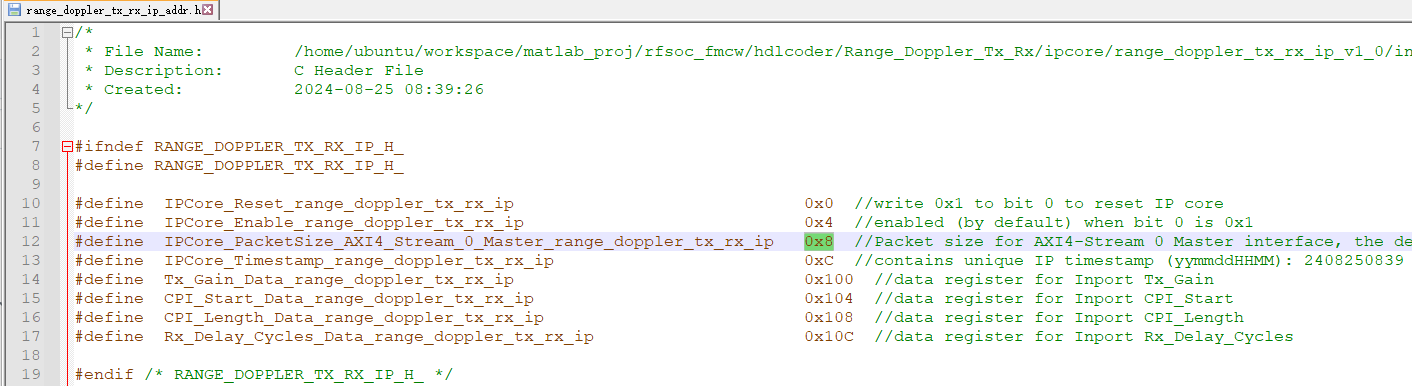

In [47]:
packet_size = range_doppler_txrx.read(0x8)
packet_size

32768

In [48]:
ip_enabled = range_doppler_txrx.read(0x4)
ip_enabled

1

In [49]:
CPI_Started = range_doppler_txrx.read(0x104)
CPI_Started

0

In [50]:
CPI_Length = range_doppler_txrx.read(0x108)
CPI_Length

0

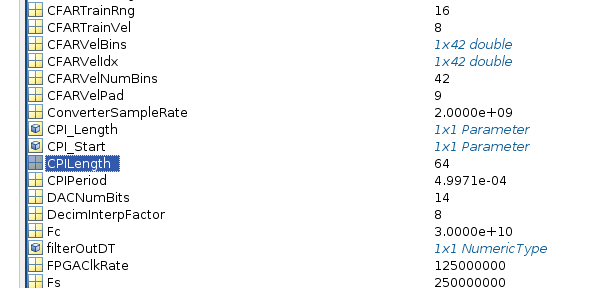

In [51]:
range_doppler_txrx.write(0x108, 64)

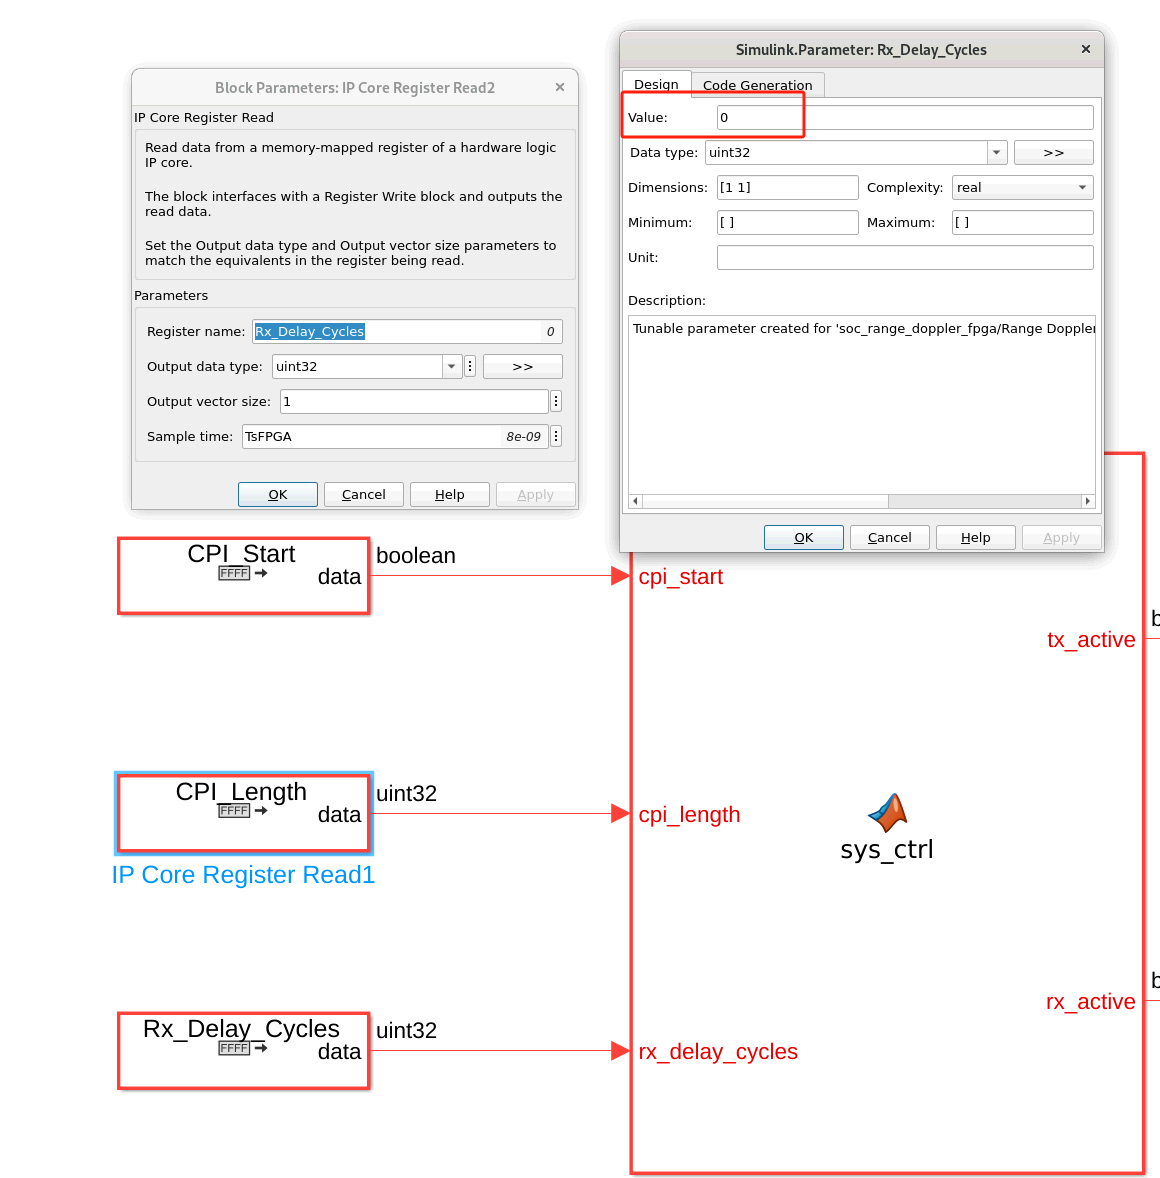

In [52]:
Rx_Delay_Cycles = range_doppler_txrx.read(0x10C)
Rx_Delay_Cycles

0

In [53]:
range_doppler_txrx.write(0x104, 1)